### Import Necessary Libraries

In [ ]:
import warnings
import re
import nltk
import string
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from tqdm.auto import tqdm

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from torchtext.vocab import GloVe
from torch.utils.data import DataLoader

### Setup Workspace

In [ ]:
nltk.download('stopwords')
nltk.download("wordnet", '/root/nltk_data')

tqdm.pandas()
warnings.filterwarnings("ignore")

glove = GloVe(name="6B", dim=50)

In [3]:
df = pd.read_csv('/kaggle/input/first-quora-dataset/q_quora.csv')

df = df.drop(columns=[
    'Unnamed: 6',
    'Unnamed: 7',
    'Unnamed: 8',
    'Unnamed: 9',
    'Unnamed: 10',
    'Unnamed: 11',
    'Unnamed: 12'
], axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# EDA (Exploratory Data Analysis)

### Data columns
**id:** id for a training set question pair

**qid1,qid2:** unique ids of each question 

**question1, question2:** the full text of the question

**is_duplicate: target label:** 1: two questions have the same meaning, 0: two questions do not have the same meaning

Our dataset consists of over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.

In [4]:
print('Shape of the dataframe:', df.shape)
print("Column's name:", df.columns)

Shape of the dataframe: (404351, 6)
Column's name: Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [5]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate    object
dtype: object

### Ratio between duplicates questions pairs
In our dataset's elegant asymmetry, non-duplicate questions dominate at 63%, casting a vast net of diversity. Meanwhile, the 37% of duplicate questions echo a shared resonance, creating a compelling contrast. 

In [6]:
df = df[(df['is_duplicate'] == "0") | (df['is_duplicate'] == "1")]
df.is_duplicate.value_counts()

is_duplicate
0    254748
1    149267
Name: count, dtype: int64


In [0]:
is_duplicate_counts = df['is_duplicate'].value_counts()

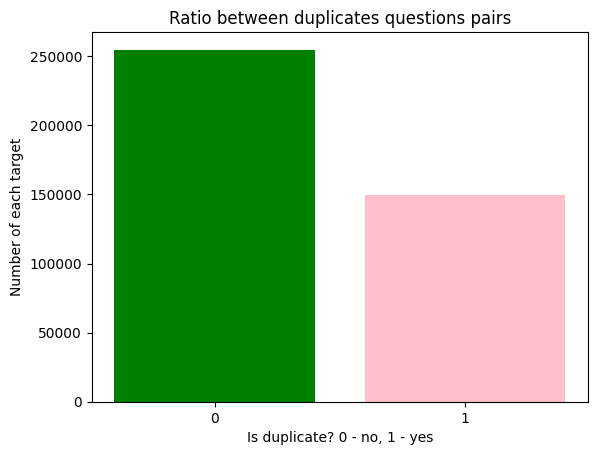

In [7]:
colors = {"0": "green", "1": "pink"}

_, ax = plt.subplots()
ax.bar(
    is_duplicate_counts.index,
    is_duplicate_counts.values,
    tick_label=["0", "1"],
    color=[colors[str(x)] for x in is_duplicate_counts.index]
)

ax.set_title('Ratio between duplicates questions pairs')
ax.set_xlabel('Is duplicate? 0 - no, 1 - yes')
ax.set_ylabel('Number of each target')
ax.set_xticks([0, 1])

plt.show()

In [8]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
df = df.dropna(subset=['question1', 'question2'])

### Distribution of Question Lengths

In [0]:
df['q1_length'] = df['question1'].apply(len)
df['q2_length'] = df['question2'].apply(len)

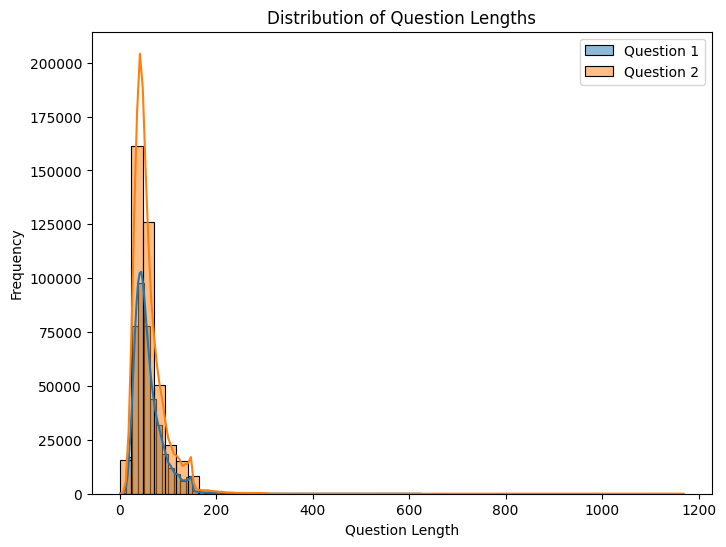

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(df['q1_length'], bins=50, label='Question 1', kde=True)
sns.histplot(df['q2_length'], bins=50, label='Question 2', kde=True)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Question Lengths')
plt.show()

In [11]:
min_q_length = min(df['q1_length'].min(), df['q2_length'].min())
max_q_length = max(df['q1_length'].max(), df['q2_length'].max())

print("Minimum length of question:", min_q_length)
print("Maximum length of question:", max_q_length)

Minimum length of question: 1
Maximum length of question: 1169


### Analyzing Special Characters

In [0]:
df['q1_special_chars'] = df['question1'].apply(lambda x: len([char for char in str(x) if char.isalnum() == False]))
df['q2_special_chars'] = df['question2'].apply(lambda x: len([char for char in str(x) if char.isalnum() == False]))

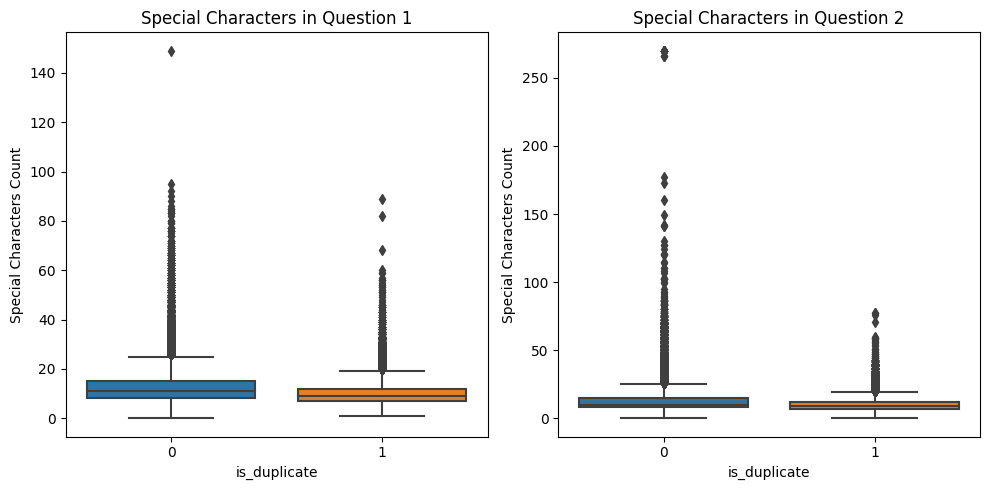

In [12]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(x='is_duplicate', y='q1_special_chars', data=df, ax=axes[0])
axes[0].set_title('Special Characters in Question 1')
axes[0].set_xlabel('is_duplicate')
axes[0].set_ylabel('Special Characters Count')

sns.boxplot(x='is_duplicate', y='q2_special_chars', data=df, ax=axes[1])
axes[1].set_title('Special Characters in Question 2')
axes[1].set_xlabel('is_duplicate')
axes[1].set_ylabel('Special Characters Count')

plt.tight_layout()
plt.show()

### Analyzing Stopwords

In [0]:
stop_words = set(stopwords.words('english'))

df['q1_stopwords'] = df['question1'].apply(
    lambda x: len([word for word in str(x).lower().split() if word in stop_words])
)

df['q2_stopwords'] = df['question2'].apply(
    lambda x: len([word for word in str(x).lower().split() if word in stop_words])
)

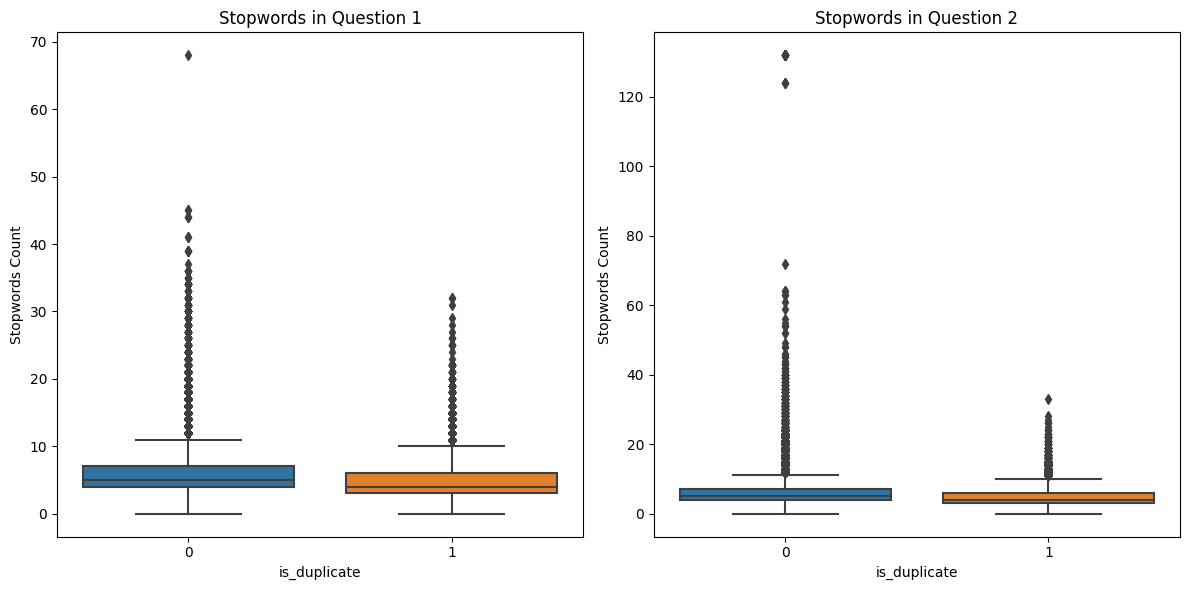

In [14]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(x='is_duplicate', y='q1_stopwords', data=df, ax=axes[0])
axes[0].set_title('Stopwords in Question 1')
axes[0].set_xlabel('is_duplicate')
axes[0].set_ylabel('Stopwords Count')

sns.boxplot(x='is_duplicate', y='q2_stopwords', data=df, ax=axes[1])
axes[1].set_title('Stopwords in Question 2')
axes[1].set_xlabel('is_duplicate')
axes[1].set_ylabel('Stopwords Count')

plt.tight_layout()
plt.show()

### Word Clouds for Questions

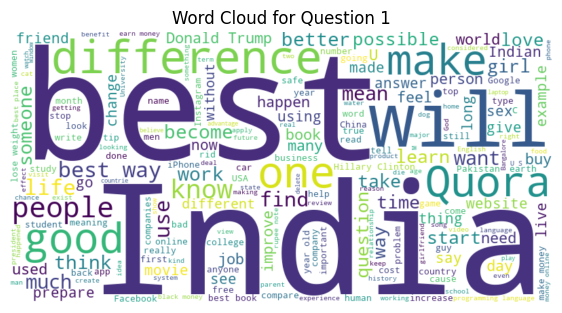

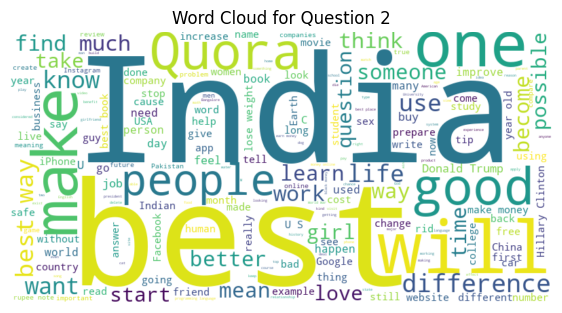

In [16]:
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['question1']))
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question 1')
plt.show()

wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['question2']))
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question 2')
plt.show()

### Common Words in Questions

In [17]:
words_question1 = ' '.join(df['question1']).lower().split()
words_question2 = ' '.join(df['question2']).lower().split()

counter_question1 = Counter(words_question1)
counter_question2 = Counter(words_question2)

print("Most common words in Question 1:", counter_question1.most_common(10))
print("Most common words in Question 2:", counter_question2.most_common(10))

Most common words in Question 1: [('the', 188089), ('what', 156474), ('is', 133647), ('how', 108620), ('a', 101050), ('i', 100961), ('to', 98089), ('in', 96745), ('of', 79426), ('do', 75839)]
Most common words in Question 2: [('the', 187798), ('what', 154248), ('is', 134989), ('i', 111924), ('how', 110278), ('a', 108921), ('to', 105743), ('in', 97796), ('of', 79329), ('do', 78790)]


### Common words between question1 and question2

In the elegant tableau of our box plot, a clear story emerges. Duplicated questions (is_duplicate = 1) reveal a rich tapestry of shared words. On average, these questions exhibit a deeper linguistic kinship, as indicated by a higher count of common words. It's a testament to their inherent similarity, a poetic dance of language and meaning.

In [0]:
df['common_words'] = df.apply(
    lambda row: set(row['question1'].lower().split()).intersection(set(row['question2'].lower().split())),
    axis=1
)

df['common_words_count'] = df['common_words'].apply(len)

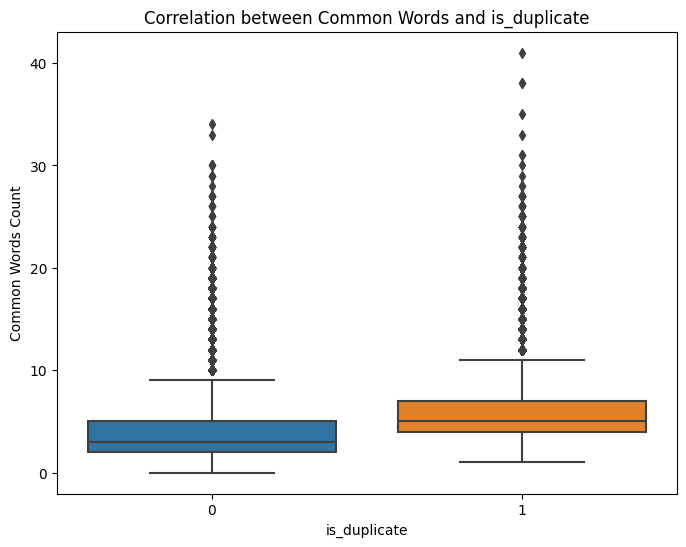

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_duplicate', y='common_words_count', data=df)
plt.title('Correlation between Common Words and is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Common Words Count')
plt.show()

### Unigrams Frequency Analysis

In [0]:
df['questions_combined'] = df['question1'] + ' ' + df['question2']
vectorizer = CountVectorizer(stop_words='english')
unigrams = vectorizer.fit_transform(df['questions_combined'])
unigram_frequencies = np.array(unigrams.sum(axis=0)).squeeze()

In [ ]:
feature_names = vectorizer.get_feature_names_out()

unigram_freq_df = pd.DataFrame({'unigram': feature_names, 'frequency': unigram_frequencies})
unigram_freq_df = unigram_freq_df.sort_values(by='frequency', ascending=False)

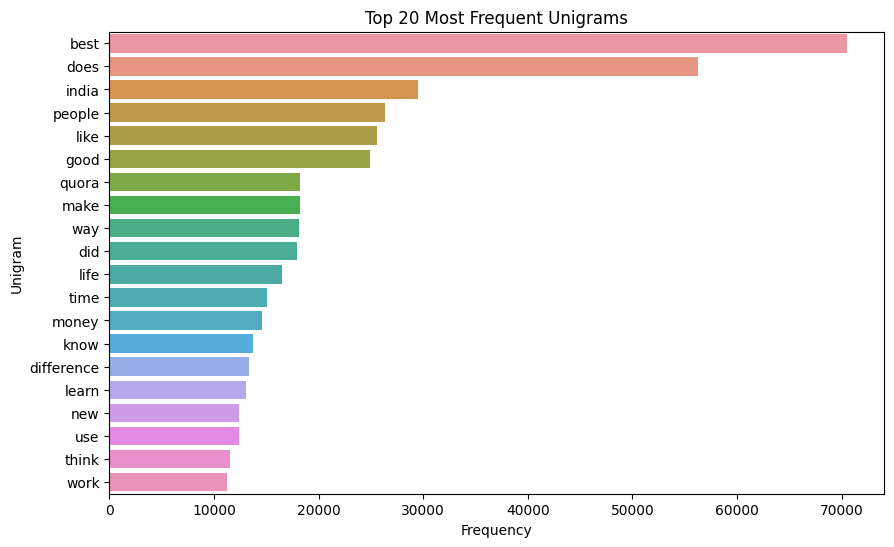

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='unigram', data=unigram_freq_df.head(20))
plt.xlabel('Frequency')
plt.ylabel('Unigram')
plt.title('Top 20 Most Frequent Unigrams')
plt.show()

### Unigrams Length Analysis

In [0]:
unigram_lengths = df['questions_combined'].apply(lambda x: len(str(x).split()))

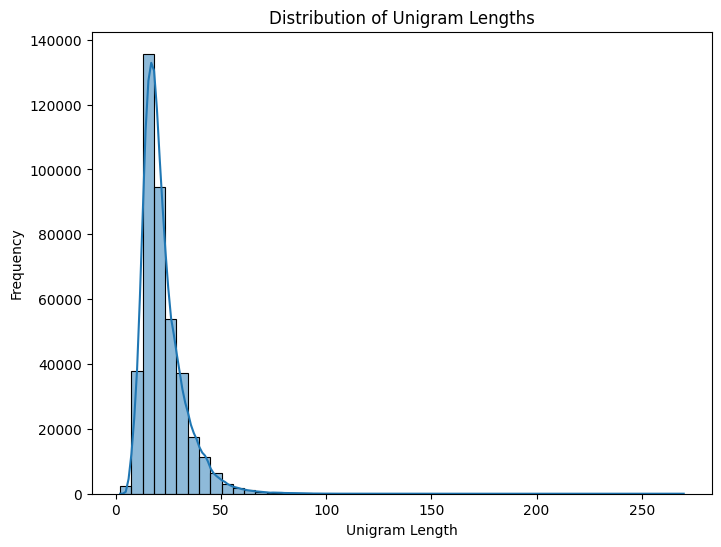

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(unigram_lengths, bins=50, kde=True)
plt.xlabel('Unigram Length')
plt.ylabel('Frequency')
plt.title('Distribution of Unigram Lengths')
plt.show()

In [21]:
min_unigram_length = unigram_lengths.min()
max_unigram_length = unigram_lengths.max()

print("Minimum length of unigram:", min_unigram_length)
print("Maximum length of unigram:", max_unigram_length)

Minimum length of unigram: 2
Maximum length of unigram: 270


In [22]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,q1_special_chars,q2_special_chars,q1_stopwords,q2_stopwords,common_words,common_words_count,questions_combined
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,"{guide, to, share, is, step, in, the, by, what...",10,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,12,17,4,4,"{(koh-i-noor), what, the, kohinoor}",4,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,"{internet, speed, can, how}",4,How can I increase the speed of my internet co...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,12,18,7,4,{},0,Why am I mentally very lonely? How can I solve...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,15,7,3,2,"{in, which}",2,"Which one dissolve in water quikly sugar, salt..."


# Data Engineering

## Common preprocessing

Following techniques will be applied: lowercase, removing of stop words, removing of punctuation marks, stemming and basic typo correction.

### Punctuation

In [25]:
df['q1_preprocessed'] = df['question1'].str.translate(str.maketrans('', '', string.punctuation))
df['q2_preprocessed'] = df['question2'].str.translate(str.maketrans('', '', string.punctuation))

### Numbers

In [27]:
df['q1_preprocessed'] = df['q1_preprocessed'].progress_apply(lambda sentence: re.sub(r'[0-9]+', '', sentence))
df['q2_preprocessed'] = df['q2_preprocessed'].progress_apply(lambda sentence: re.sub(r'[0-9]+', '', sentence))

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

### Tokenization

In [29]:
df['q1_preprocessed'] = df['q1_preprocessed'].progress_apply(lambda sentence: word_tokenize(sentence))
df['q2_preprocessed'] = df['q2_preprocessed'].progress_apply(lambda sentence: word_tokenize(sentence))

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

### Lowercase

In [30]:
df['q1_preprocessed'] = df['q1_preprocessed'].progress_apply(lambda x: [word.lower() for word in x])
df['q2_preprocessed'] = df['q2_preprocessed'].progress_apply(lambda x: [word.lower() for word in x])

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

### Stop words

In [32]:
stop = stopwords.words('english')

df['q1_preprocessed'] = df['q1_preprocessed'].progress_apply(lambda x: [
    word 
    for word in x 
    if word not in stop
])

df['q2_preprocessed'] = df['q2_preprocessed'].progress_apply(lambda x: [
    word 
    for word in x 
    if word not in stop
])

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

In [33]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,q1_special_chars,q2_special_chars,q1_stopwords,q2_stopwords,common_words,common_words_count,questions_combined,q1_preprocessed,q2_preprocessed
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,"{guide, to, share, is, step, in, the, by, what...",10,What is the step by step guide to invest in sh...,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,12,17,4,4,"{(koh-i-noor), what, the, kohinoor}",4,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,"{internet, speed, can, how}",4,How can I increase the speed of my internet co...,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,12,18,7,4,{},0,Why am I mentally very lonely? How can I solve...,"[mentally, lonely, solve]","[find, remainder, mathmath, divided]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,15,7,3,2,"{in, which}",2,"Which one dissolve in water quikly sugar, salt...","[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


Actually, this takes a while, so now it is commented.

### Lemmatization

In [0]:
lemmatizer = WordNetLemmatizer()

In [43]:
df['q1_preprocessed'] = df['q1_preprocessed'].progress_apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['q2_preprocessed'] = df['q2_preprocessed'].progress_apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

In [44]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,q1_special_chars,q2_special_chars,q1_stopwords,q2_stopwords,common_words,common_words_count,questions_combined,q1_preprocessed,q2_preprocessed
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,"{guide, to, share, is, step, in, the, by, what...",10,What is the step by step guide to invest in sh...,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,12,17,4,4,"{(koh-i-noor), what, the, kohinoor}",4,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."


## Adding more features

### N-grams

In [46]:
def get_ngrams(tokens, length):
    ngrams = []
    if len(tokens) < length:
        return ngrams
    ngrams.extend(nltk.ngrams(tokens, length))
    return ngrams

In [47]:
ngrams_length = 3
df['q1_ngrams'] = df['q1_preprocessed'].progress_apply(lambda sentence: get_ngrams(sentence, ngrams_length))
df['q2_ngrams'] = df['q2_preprocessed'].progress_apply(lambda sentence: get_ngrams(sentence, ngrams_length))

  0%|          | 0/404012 [00:00<?, ?it/s]

  0%|          | 0/404012 [00:00<?, ?it/s]

## Preparing for training

### Splitting

In [62]:
data = df.drop(columns=['question1', 'question2', 'id', 'qid1', 'qid2', 'questions_combined'])

In [63]:
test_size = 0.2
val_size = 0.2

train_val, test = train_test_split(data, test_size=test_size, random_state=420)
train, val = train_test_split(train_val, test_size=val_size, random_state=420)

### Creating the Dataloaders

In [ ]:
torch.manual_seed(420)

device = torch.device(
    'cuda'
    if torch.cuda.is_available() else
    'cpu'
)

In [ ]:
max_words = 50
embed_len = 50
batch_size = 512

In [140]:
def collate_batch(batch):
    label_list = []
    embeddings_tensor = torch.zeros(len(batch), 2, max_words, embed_len)
    for i, _data in enumerate(batch):
        (
            label,
            q1_length, q2_length,
            q1_special_chars, q2_special_chars,
            q1_stopwords, q2_stopwords,
            common_words, common_words_count,
            q1_preprocessed, q2_preprocessed,
            q1_ngrams, q2_ngrams
        ) = _data

        q1_preprocessed = (
            q1_preprocessed + [""] * (max_words - len(q1_preprocessed))
            if len(q1_preprocessed) < max_words else
            q1_preprocessed[:max_words]
        )

        q2_preprocessed = (
            q2_preprocessed + [""] * (max_words - len(q2_preprocessed))
            if len(q1_preprocessed) < max_words else
            q2_preprocessed[:max_words]
        )

        label_list.append(int(label))
        embeddings_tensor[i, 0] = glove.get_vecs_by_tokens(q1_preprocessed)
        embeddings_tensor[i, 1] = glove.get_vecs_by_tokens(q2_preprocessed)

    label_list = torch.tensor(label_list, dtype=torch.int64)
    return embeddings_tensor.reshape(len(batch), -1).to(device), label_list.to(device)

In [0]:
train_dataloader = DataLoader(
    train.to_numpy(),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

In [141]:
val_dataloader = DataLoader(
    val.to_numpy(),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)